In [2]:
import pandas as pd
import numpy as np

%matplotlib inline

### Walmart Sales Data

For the independent practice, we will analyze the weekly sales data from Walmart over a two year period from 2010 to 2012.

The data is again separated by store and by department, but we will focus on analyzing one store for simplicity.

The data includes:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week


#### Loading the data and setting the DateTimeIndex

In [3]:
data = pd.read_csv('../../assets/dataset/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


#### Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [4]:
# Filter to store 1 sales and average over weeks
store1_sales = data[data.Store == 1][['Weekly_Sales']].resample('W', 'sum')
store1_sales.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app


,Weekly_Sales
Date,
2010-02-07,1643690.90
2010-02-14,1641957.44
2010-02-21,1611968.17
2010-02-28,1409727.59
2010-03-07,1554806.68


#### Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=3,center=False).mean()
  if __name__ == '__main__':


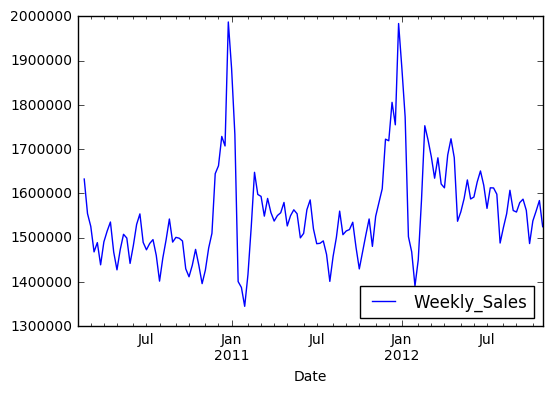

In [5]:
pd.rolling_mean(store1_sales[['Weekly_Sales']], 3).plot()

#### Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and/or create an autocorrelation plot.

In [6]:
print('Autocorrelation 1: ', store1_sales['Weekly_Sales'].autocorr(1))
print('Autocorrelation 3: ', store1_sales['Weekly_Sales'].autocorr(3))
print('Autocorrelation 52: ', store1_sales['Weekly_Sales'].autocorr(52))

('Autocorrelation 1: ', 0.30215827941131262)
('Autocorrelation 3: ', 0.059799235066717034)
('Autocorrelation 52: ', 0.89537602947770101)


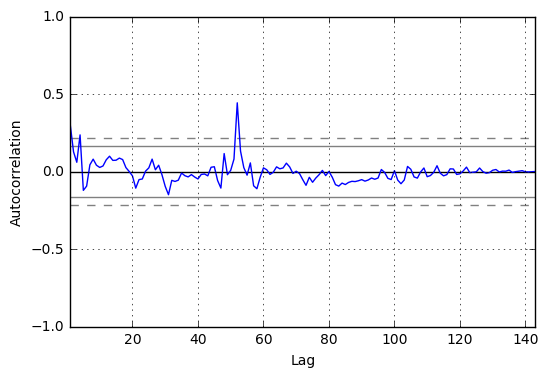

In [7]:
from pandas.tools.plotting import autocorrelation_plot

autocorrelation_plot(store1_sales['Weekly_Sales'])

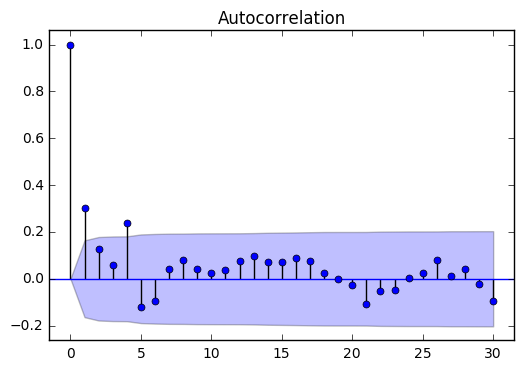

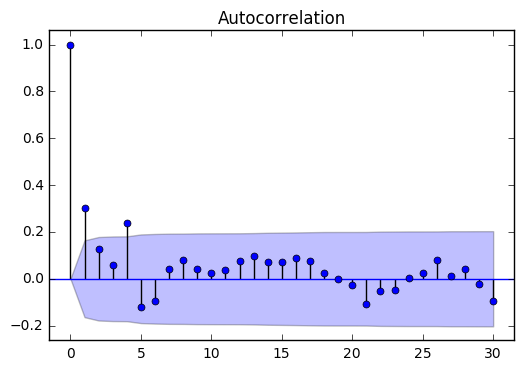

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_sales['Weekly_Sales'], lags=30)

# Components 1 and 2 seem particularly useful for autoregression, perhaps up to 4
# In the plot above notice, spike at around 52 - implying a yearly pattern as well
# No random spikes, probably not much use for a moving average model

#### Split the weekly sales data in a training and test set - using 75% of the data for training

In [9]:
n = len(store1_sales.Weekly_Sales)

train = store1_sales.Weekly_Sales[:int(.75*n)]
test = store1_sales.Weekly_Sales[int(.75*n):]

#### Create an AR(1) model on the training data and compute the mean absolute error of the predictions.

In [11]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

In [12]:
model = sm.tsa.ARIMA(train, (1, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81839.338631623992)


//anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(1, 0)   Log Likelihood               -1434.663
Method:                       css-mle   S.D. of innovations         160916.939
Date:                Tue, 10 Jan 2017   AIC                           2875.327
Time:                        19:55:48   BIC                           2883.345
Sample:                    02-07-2010   HQIC                          2878.577
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   2.26e+04     68.293      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.3147      0.093      3.399      0.001         0.133     0.496
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1779           +0.0000j            3.1779            0.0000
-----------------------------------------------------------------------------
"""

#### Plot the residuals - where are their significant errors.

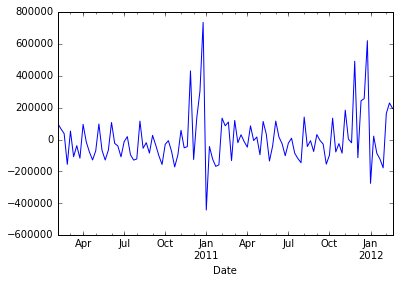

In [14]:
model.resid.plot()

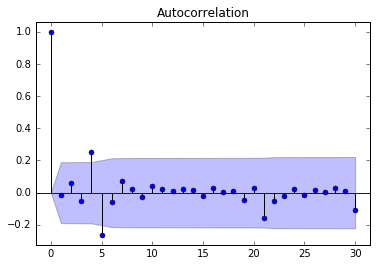

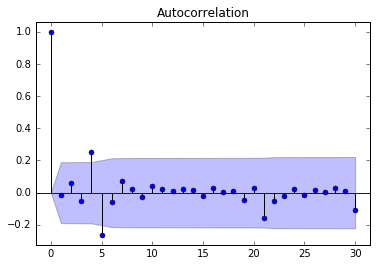

In [15]:
plot_acf(model.resid, lags=30)

#### Compute and AR(2) model and an ARMA(2, 2) model - does this improve your mean absolute error on the held out set.

In [16]:
model = sm.tsa.ARIMA(train, (2, 0, 0)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 81203.240909485947)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 0)   Log Likelihood               -1434.482
Method:                       css-mle   S.D. of innovations         160638.038
Date:                Tue, 08 Mar 2016   AIC                           2876.963
Time:                        12:48:22   BIC                           2887.655
Sample:                    02-07-2010   HQIC                          2881.298
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06    2.4e+04     64.349      0.000       1.5e+06  1.59e+06
ar.L1.Weekly_Sales     0.2974      0.097      3.075      0.003         0.108     0.487
ar.L2.Weekly_Sales     0.0589      0.098      0.603      0.548        -0.132     0.250
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3081           +0.0000j            2.3081            0.0000
AR.2           -7.3588           +0.0000j            7.3588            0.5000
-----------------------------------------------------------------------------
"""

In [17]:
model = sm.tsa.ARIMA(train, (2, 0, 2)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=True, 
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 80502.745386798299)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  107
Model:                     ARMA(2, 2)   Log Likelihood               -1425.781
Method:                       css-mle   S.D. of innovations         144113.350
Date:                Tue, 08 Mar 2016   AIC                           2863.563
Time:                        12:48:23   BIC                           2879.600
Sample:                    02-07-2010   HQIC                          2870.064
                         - 02-19-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.544e+06   1.92e+04     80.327      0.000      1.51e+06  1.58e+06
ar.L1.Weekly_Sales    -1.0400      0.090    -11.583      0.000        -1.216    -0.864
ar.L2.Weekly_Sales    -0.4701      0.087     -5.381      0.000        -0.641    -0.299
ma.L1.Weekly_Sales     1.4692      0.058     25.424      0.000         1.356     1.582
ma.L2.Weekly_Sales     0.9998      0.074     13.576      0.000         0.855     1.144
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1060           -0.9507j            1.4584           -0.3870
AR.2           -1.1060           +0.9507j            1.4584            0.3870
MA.1           -0.7347           -0.6785j            1.0001           -0.3813
MA.2           -0.7347           +0.6785j            1.0001            0.3813
-----------------------------------------------------------------------------
"""

#### Finally, compute an ARIMA model to improve your prediction error - iterate on the p, q, and parameters comparing the model's performance.

In [18]:
model = sm.tsa.ARIMA(train, (2, 1, 3)).fit()

predictions = model.predict(
    '2012-02-27',
    '2012-10-29',
    dynamic=False, 
    typ='levels'
)

print("Mean absolute error: ", mean_absolute_error(test, predictions))
model.summary()

('Mean absolute error: ', 77789.494825392394)


/Users/arahuja/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Weekly_Sales   No. Observations:                  106
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1413.622
Method:                       css-mle   S.D. of innovations         142943.992
Date:                Tue, 08 Mar 2016   AIC                           2841.243
Time:                        12:48:27   BIC                           2859.887
Sample:                    02-14-2010   HQIC                          2848.800
                         - 02-19-2012                                         
========================================================================================
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                  577.5354    622.025      0.928      0.355      -641.611  1796.682
ar.L1.D.Weekly_Sales    -1.0481      0.090    -11.609      0.000        -1.225    -0.871
ar.L2.D.Weekly_Sales    -0.4778      0.088     -5.442      0.000        -0.650    -0.306
ma.L1.D.Weekly_Sales     0.4694      0.116      4.057      0.000         0.243     0.696
ma.L2.D.Weekly_Sales    -0.4693      0.152     -3.095      0.003        -0.766    -0.172
ma.L3.D.Weekly_Sales    -0.9997      0.123     -8.098      0.000        -1.242    -0.758
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0967           -0.9434j            1.4466           -0.3869
AR.2           -1.0967           +0.9434j            1.4466            0.3869
MA.1            1.0001           -0.0000j            1.0001           -0.0000
MA.2           -0.7348           -0.6784j            1.0001           -0.3813
MA.3           -0.7348           +0.6784j            1.0001            0.3813
-----------------------------------------------------------------------------
"""